In [79]:
from collections import defaultdict
from copy import deepcopy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi


from skimage import feature
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import erosion, dilation, rectangle


%matplotlib inline



## Cleaning the image

First, lets take a look at a sample image

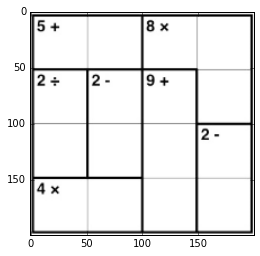

In [398]:
sample4x4_orig = ndi.imread('sample4x4_3.jpg', mode='L')
sample4x4 = resize(sample4x4_orig, (200,200))
plt.imshow(sample4x4, cmap=mpl.cm.Greys_r)

First find the corners and crop the image to these corners, then resize

binarize image

In [399]:
def binarize(matrix, threshold=0.3):
    temp = deepcopy(matrix)
    for m in range(len(temp)):
        for n in range(len(temp[m])):
            if temp[m][n] < threshold:
                temp[m][n] = 0.0
            else:
                temp[m][n] = 1.0
                
    return temp

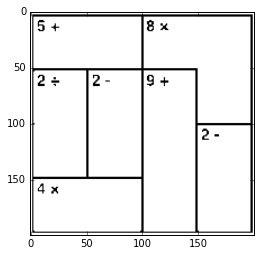

In [400]:
binar = deepcopy(sample4x4)

binar = binarize(binar)
plt.imshow(binar, cmap=mpl.cm.Greys_r)

In [401]:
binar[:6,:6]

array([[ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  1.,  1.]])

In [402]:
binar[193:,193:]

array([[ 1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [403]:
# up left
cond = False
for m in range(7):
    for n in range(7):
        if binar[m][n] == 0:
            up_left = [m,n]
            cond = True
            break
    if cond==True:
        break
        
# low right
cond = False
for m in range(199,192,-1):
    for n in range(199,192,-1):
        #print(m,n, binar[m][n])
        if binar[m][n] == 0:
            low_right = [m,n]
            cond = True
            break
    if cond==True:
        break

Bounds below are the black border

In [404]:
binar[3:198,2:198]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Crop sample(unbinarized) > resize to 200x200 > binarize

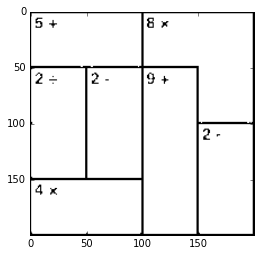

In [426]:
sample4x4_crop = resize(sample4x4[up_left[0]:low_right[0]+1,up_left[1]:low_right[1]+1], (200,200))
binar = binarize(sample4x4_crop)
plt.imshow(binar, cmap=mpl.cm.Greys_r)

Next do some [Morphological filtering](http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html)

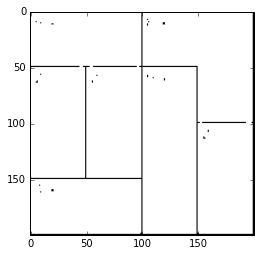

In [419]:
selem = rectangle(2,2)
dil = dilation(binar, selem)
#dil = erosion(dil)
plt.imshow(dil, cmap=mpl.cm.Greys_r)

In [420]:
dil[25,140:160]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

There maybe some greying so binarize again:

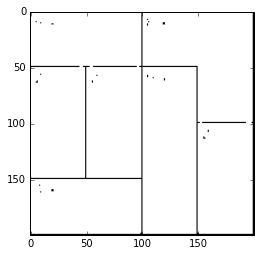

In [421]:
dil = binarize(dil)
plt.imshow(dil, cmap=mpl.cm.Greys_r)

Looks good but we need two things:

1. Clear the corners to get a clean image to find clusters
2. Add the corner numbers back to get the final image to machine learn on

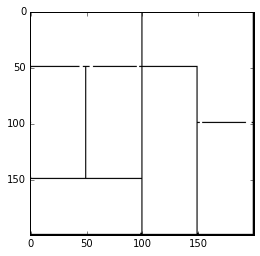

In [422]:
cluster_image = deepcopy(dil)

for i in range(4):
    for j in range(4):
        cluster_image[i*50+5:i*50+40,j*50+3:j*50+38] = np.zeros((35,35))+1
        
plt.imshow(cluster_image, cmap=mpl.cm.Greys_r)

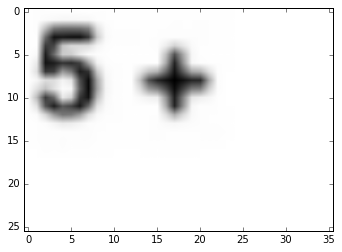

In [423]:
plt.imshow(sample4x4_crop[3:29,3:39], cmap=mpl.cm.Greys_r)

I will add the above corner back into the image and repeat for all corners. I don't like using the adding the original unbinarized numbers, but it is difficult to consistently binarize them

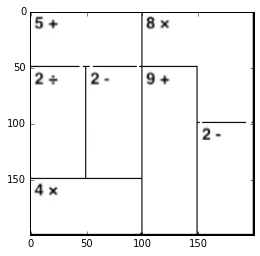

In [425]:
final = deepcopy(dil)

for i in range(4):
    for j in range(4):
        final[i*50+3:i*50+25,j*50+3:j*50+40] = sample4x4_crop[i*50+3:i*50+25,j*50+3:j*50+40]
        
plt.imshow(final, cmap=mpl.cm.Greys_r)

Awesome, Now I need to label the clusters

## Clustering the boxes

Get a clean spot in each box to travel through the middle between boxes.

In [428]:
centroids = [[[25+50*i,25+50*j] for j in range(0,4)] for i in range(0,4)]
centroids

[[[25, 25], [25, 75], [25, 125], [25, 175]],
 [[75, 25], [75, 75], [75, 125], [75, 175]],
 [[125, 25], [125, 75], [125, 125], [125, 175]],
 [[175, 25], [175, 75], [175, 125], [175, 175]]]

In [588]:
#this is for linking the above image locations to locations in the eventual cluster indices
cluster_loc_dict = defaultdict(list)

for m in range(len(centroids)):
    for n in range(len(centroids[m])):
        cluster_loc_dict[tuple(centroids[m][n])] = (m,n)

In [589]:
cluster_loc_dict

defaultdict(list,
            {(25, 25): (0, 0),
             (25, 75): (0, 1),
             (25, 125): (0, 2),
             (25, 175): (0, 3),
             (75, 25): (1, 0),
             (75, 75): (1, 1),
             (75, 125): (1, 2),
             (75, 175): (1, 3),
             (125, 25): (2, 0),
             (125, 75): (2, 1),
             (125, 125): (2, 2),
             (125, 175): (2, 3),
             (175, 25): (3, 0),
             (175, 75): (3, 1),
             (175, 125): (3, 2),
             (175, 175): (3, 3)})

Label dict will be used for storing the labels of each cluster. For example 

{

 [0,0] : 1,

 [0,1] : 1,

 [0,2] : 2,

.

.

.

}

In [468]:
label_dict = {tuple(v):0 for _,v in cluster_loc_dict.items()}

In [469]:
label_dict

{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 0,
 (1, 0): 0,
 (1, 1): 0,
 (1, 2): 0,
 (1, 3): 0,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 0,
 (2, 3): 0,
 (3, 0): 0,
 (3, 1): 0,
 (3, 2): 0,
 (3, 3): 0}

Get all neighboring pairs even duplicates

In [590]:
neighbor_pairs = []

for m in range(len(centroids)):
    for n in range(len(centroids[m])):
        #skip right edge
        if n < (len(centroids[m])-1):
            neighbor_pairs.append([centroids[m][n], centroids[m][n+1]])
        #skip bottom edge
        if m < (len(centroids)-1):
            neighbor_pairs.append([centroids[m][n], centroids[m+1][n]])
        #skip top edge
        if m > 0:
            neighbor_pairs.append([centroids[m][n], centroids[m-1][n]])
        #skip left edge
        if n > 0:
            neighbor_pairs.append([centroids[m][n], centroids[m][n-1]])       
            
print(neighbor_pairs)

[[[25, 25], [25, 75]], [[25, 25], [75, 25]], [[25, 75], [25, 125]], [[25, 75], [75, 75]], [[25, 75], [25, 25]], [[25, 125], [25, 175]], [[25, 125], [75, 125]], [[25, 125], [25, 75]], [[25, 175], [75, 175]], [[25, 175], [25, 125]], [[75, 25], [75, 75]], [[75, 25], [125, 25]], [[75, 25], [25, 25]], [[75, 75], [75, 125]], [[75, 75], [125, 75]], [[75, 75], [25, 75]], [[75, 75], [75, 25]], [[75, 125], [75, 175]], [[75, 125], [125, 125]], [[75, 125], [25, 125]], [[75, 125], [75, 75]], [[75, 175], [125, 175]], [[75, 175], [25, 175]], [[75, 175], [75, 125]], [[125, 25], [125, 75]], [[125, 25], [175, 25]], [[125, 25], [75, 25]], [[125, 75], [125, 125]], [[125, 75], [175, 75]], [[125, 75], [75, 75]], [[125, 75], [125, 25]], [[125, 125], [125, 175]], [[125, 125], [175, 125]], [[125, 125], [75, 125]], [[125, 125], [125, 75]], [[125, 175], [175, 175]], [[125, 175], [75, 175]], [[125, 175], [125, 125]], [[175, 25], [175, 75]], [[175, 25], [125, 25]], [[175, 75], [175, 125]], [[175, 75], [125, 75]], 

In [591]:
neighbor_pairs[0]

[[25, 25], [25, 75]]

In [592]:
neighbors_dict = defaultdict(list)

for link in neighbor_pairs:
    neighbors_dict[tuple(link[0])].append(link[1])

This will allow me to cycle through the neighbors of each box

In [593]:
neighbors_dict

defaultdict(list,
            {(25, 25): [[25, 75], [75, 25]],
             (25, 75): [[25, 125], [75, 75], [25, 25]],
             (25, 125): [[25, 175], [75, 125], [25, 75]],
             (25, 175): [[75, 175], [25, 125]],
             (75, 25): [[75, 75], [125, 25], [25, 25]],
             (75, 75): [[75, 125], [125, 75], [25, 75], [75, 25]],
             (75, 125): [[75, 175], [125, 125], [25, 125], [75, 75]],
             (75, 175): [[125, 175], [25, 175], [75, 125]],
             (125, 25): [[125, 75], [175, 25], [75, 25]],
             (125, 75): [[125, 125], [175, 75], [75, 75], [125, 25]],
             (125, 125): [[125, 175], [175, 125], [75, 125], [125, 75]],
             (125, 175): [[175, 175], [75, 175], [125, 125]],
             (175, 25): [[175, 75], [125, 25]],
             (175, 75): [[175, 125], [125, 75], [175, 25]],
             (175, 125): [[175, 175], [125, 125], [175, 75]],
             (175, 175): [[125, 175], [175, 125]]})

How this will work:
    * Start in the top left corner. Label it.
    * try walking right. If blocked, try another direction. If not, move to that box, label it the same. 

In [594]:
class cluster_grouper(object):
    
    def __init__ (self, image):
        self.image_arr = image
        # unique_label is the current # of unique labels used
        self.unique_label = 1

        # labeled_boxes keeps track of the boxes that have already been labeled
        self.labeled_boxes = []

        # create label_dict to store each boxes location
        self.label_dict = {tuple(v):0 for _,v in cluster_loc_dict.items()}
                
    
        
    def check_neighbors(self, box_to_check, path=[]):
    #if neighbor is unlabeled and connected, 
    #step to that one, 
    #append current cell to path, 
    #call check neighbors
        #check neighbors to see if any paths are blocked append T/F to if path blocked
        if box_to_check not in path:
            path.append(box_to_check)
        
        for neighbor in neighbors_dict[box_to_check]:
            # print(neighbor)
            # skip a neighbor that you've come from
            if tuple(neighbor) not in path:
                top = box_to_check[0]
                bottom = neighbor[0]
                left = box_to_check[1]
                right = neighbor[1]
                
                # need to check if top/bottom or left/right are same value, need to add 1
                if top == bottom:
                    bottom +=1
                if left == right:
                    right +=1
                    
                # also swap top/bottom or left/right if matching upwards or leftwards
                if right < left:
                    left,right = right,left
                if top > bottom:
                    top,bottom = bottom,top
                
                # if there is a black pixel in path, skip
                if 0 in self.image_arr[top:bottom,left:right].flatten():
                    continue
                # else check the neighbor and extend path of result recursively
                else:
                    path.extend(self.check_neighbors(tuple(neighbor), path))
                    path = list(set(path))
                               
        return path
    
    def execute(self):
        for box in sorted(neighbors_dict.keys(), key=lambda x: x):
            #only clusters that haven't been labeled should appear not labeled,
            #once an unlabeled cluster is found, all boxes in that cluster should be labeled
            print('choosing ',box)
            print('currently labeled ',self.labeled_boxes)
            if box not in self.labeled_boxes:
                #print(box)
                connected_path = self.check_neighbors(box, path=[])
                #get only unique boxes
                print('path found : ', connected_path)
                connected_path = set(connected_path)
                #assign each box in the path a label
                for connected_box in connected_path:
                    self.label_dict[cluster_loc_dict[connected_box]] = self.unique_label
                    self.labeled_boxes.append(tuple(connected_box))
                #increment the label
                print('assigning label : ',self.unique_label, '\n')
                self.unique_label += 1
            else:
                print('its already in the set')
            
            self.labeled_boxes = list(set(self.labeled_boxes))
        return self.label_dict
                    
                    
        
        
                    
    
    
                
        

In [595]:
new_dict = cluster_grouper(cluster_image).execute()

choosing  (25, 25)
currently labeled  []
path found :  [(25, 75), (25, 25)]
assigning label :  1 

choosing  (25, 75)
currently labeled  [(25, 75), (25, 25)]
its already in the set
choosing  (25, 125)
currently labeled  [(25, 75), (25, 25)]
path found :  [(25, 125), (75, 175), (25, 175)]
assigning label :  2 

choosing  (25, 175)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175)]
its already in the set
choosing  (75, 25)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175)]
path found :  [(125, 25), (75, 25)]
assigning label :  3 

choosing  (75, 75)
currently labeled  [(25, 125), (25, 75), (75, 175), (25, 25), (25, 175), (125, 25), (75, 25)]
path found :  [(75, 75), (125, 75)]
assigning label :  4 

choosing  (75, 125)
currently labeled  [(25, 125), (25, 75), (75, 175), (75, 75), (25, 25), (125, 75), (25, 175), (125, 25), (75, 25)]
path found :  [(175, 125), (125, 125), (75, 125)]
assigning label :  5 

choosing  (75, 175)
currently labeled  [(

In [596]:
new_dict

{(0, 0): 1,
 (0, 1): 1,
 (0, 2): 2,
 (0, 3): 2,
 (1, 0): 3,
 (1, 1): 4,
 (1, 2): 5,
 (1, 3): 2,
 (2, 0): 3,
 (2, 1): 4,
 (2, 2): 5,
 (2, 3): 6,
 (3, 0): 7,
 (3, 1): 7,
 (3, 2): 5,
 (3, 3): 6}

In [598]:
cluster = np.zeros((4,4))

In [601]:
for k,v in new_dict.items():
    cluster[k[0],k[1]] = v

In [602]:
cluster

array([[ 1.,  1.,  2.,  2.],
       [ 3.,  4.,  5.,  2.],
       [ 3.,  4.,  5.,  6.],
       [ 7.,  7.,  5.,  6.]])